In [1]:
# Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as cv
import sklearn.neighbors as nb
import pandas as pd
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stemmer = EnglishStemmer(ignore_stopwords=True)
tokenize = TfidfVectorizer().build_tokenizer()


def stemmed_words(doc):
    return (stemmer.stem(w) for w in tokenize(doc))

# Function to get the tf_idf scores for a list of strings representing a title
# takes a list of strings as parameters
def pre_tfidf2(data):
    nr_pattern = re.compile(r'\b[+-]?\d*[.,]?\d+([eE][+-]?\d+)?\b')
    acronyms = re.compile(r'\b(\w)[.+:\-]')
    non_alphanum = re.compile(r'[^\w\d\-\+\s]')
    for i in range(len(data)):
        title = acronyms.sub(r'\1', data[i])
        title = non_alphanum.sub(' ', title)
        data[i] = nr_pattern.sub('NUMBER_SPECIAL_TOKEN', title)
    vectorizer = TfidfVectorizer(
        tokenizer=stemmed_words, stop_words=stopwords.words('english'), max_features=1000)
    X = vectorizer.fit_transform(data)
    # features = vectorizer.get_feature_names()
    return X.toarray()


# reading the data
dt_true = pd.read_csv('clickbait_data.txt', sep='\n', names=['Title'])
dt_false = pd.read_csv('non_clickbait_data.txt', sep='\n', names=['Title'])
dt_true = dt_true.assign(Label=lambda x: True)
dt_false = dt_false.assign(Label=lambda x: False)

# merging the data
dt = pd.concat([dt_true, dt_false], ignore_index=True)

# shulffing data
dt = shuffle(dt).reset_index(drop=True)

# computing tf-idf
X = pre_tfidf2(dt['Title'].to_list())  # tf_idf scores
y = dt['Label']  # labels

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adrian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Separation into data and label
print(X.shape)
print(y.shape)

(32000, 1000)
(32000,)


In [3]:
# Train on data. No parameters to adjust

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.neighbors as nb

cv = StratifiedKFold(n_splits=10) 

mnb = MultinomialNB()
cv_scores = cross_val_score(mnb,X=X,y=y,cv=cv)
np.mean(cv_scores)


0.9215625000000001

In [4]:
from sklearn.model_selection import cross_val_predict  
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

predicted = cross_val_predict(MultinomialNB(), X=X, y=y,  cv=cv)  

print(confusion_matrix(y, predicted))
print(accuracy_score(y, predicted))

[[14719  1282]
 [ 1228 14771]]
0.9215625


In [5]:
from sklearn.metrics import classification_report

print(classification_report(y, predicted))

              precision    recall  f1-score   support

       False       0.92      0.92      0.92     16001
        True       0.92      0.92      0.92     15999

    accuracy                           0.92     32000
   macro avg       0.92      0.92      0.92     32000
weighted avg       0.92      0.92      0.92     32000



## Adjusting probability threshold

In [6]:
# Focus on predict class 1

y2 = np.zeros((y.shape))
y2[y==0]=1
y2[y==1]=0

(X_train, X_test,  y_train, y_test) = train_test_split(X, y2, test_size=.3, random_state=1)

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'alpha': np.logspace(0.01, 2.0, num = 1000)
}

gd=GridSearchCV(estimator=MultinomialNB(), param_grid = param_grid_nb, verbose = True)

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)
best_alpha = gd.best_params_['alpha']

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
0.9209821428571429
{'alpha': 1.023292992280754}


In [11]:
# Train a classifier with the whole training data 
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train, y_train)
# Obtain probabilities for data on test set
pred = clf.predict(X_test)
# Print results with this prediction vector
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      4800
         1.0       0.92      0.92      0.92      4800

    accuracy                           0.92      9600
   macro avg       0.92      0.92      0.92      9600
weighted avg       0.92      0.92      0.92      9600



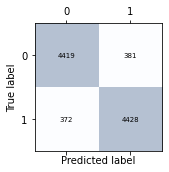

In [9]:
confmat = sklearn.metrics.confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=7)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('ConMatrix3.png', dpi=600)
plt.show()